each line in the features df: features (1711-dim or 211-dim) with a column "id"  
10 predictors telling a protein serves this certain function or not: [
    "lysis",
    "tail",
    "connector",
    "dna_rna_and_nucleotide_metabolism",
    "head_and_packaging",
    "other",
    "transcription_regulation",
    "moron_auxiliary_metabolic_gene_and_host_takeover",
    "unknown_function",
    "integration_and_excision",
]

predictor paths: "../models/best_configs/xxx(function name)_predictor.joblib"

best threshold:
[
    "lysis": 0.06,
    "tail": 0.03,
    "connector": 0.03,
    "dna_rna_and_nucleotide_metabolism": 0.04,
    "head_and_packaging": 0.01,
    "other": 0.01,
    "transcription_regulation": 0.01,
    "moron_auxiliary_metabolic_gene_and_host_takeover": 0.01,
    "unknown_function": 0.29,
    "integration_and_excision": 0.23,
]


use the 10 predictors to predict on each proteins and output the result for each protein; note that "unknown_function" use "features_211dim" and other 9 predictors use "features" which is 1711-dim

output: dataframe, where columns are: id, hit_number, hit_function;  
hit_number is the number of predictors that give positive answer (like 0 or 1), 
hit_function is the name of predictors that give positive answer (like "connector")

goal: write functions in script as much as possible so that it is easier to implement

In [1]:
import pandas as pd
import numpy as np
from joblib import load
from typing import List, Dict, Tuple, Any
from sklearn.preprocessing import StandardScaler

In [2]:
FUNCTION_NAMES = [
    "lysis",
    "tail",
    "connector",
    "dna_rna_and_nucleotide_metabolism",
    "head_and_packaging",
    "other",
    "transcription_regulation",
    "moron_auxiliary_metabolic_gene_and_host_takeover",
    "unknown_function",
    "integration_and_excision",
]

# BEST_THRESHOLDS = {
#     "lysis": 0.06,
#     "tail": 0.03,
#     "connector": 0.03,
#     "dna_rna_and_nucleotide_metabolism": 0.04,
#     "head_and_packaging": 0.01,
#     "other": 0.01,
#     "transcription_regulation": 0.01,
#     "moron_auxiliary_metabolic_gene_and_host_takeover": 0.01,
#     "unknown_function": 0.29,
#     "integration_and_excision": 0.23,
# }

THRESHOLDS = {
    "lysis": 0.5,
    "tail": 0.5,
    "connector": 0.5,
    "dna_rna_and_nucleotide_metabolism": 0.5,
    "head_and_packaging": 0.5,
    "other": 0.5,
    "transcription_regulation": 0.5,
    "moron_auxiliary_metabolic_gene_and_host_takeover": 0.5,
    "unknown_function": 0.5,
    "integration_and_excision": 0.5,
}


In [3]:
def load_predictor(function_name: str) -> Tuple[Any, StandardScaler]:
    """Load a predictor model and its scaler from the saved file."""
    model_path = f"../models/best_configs/{function_name}_predictor.joblib"
    loaded_data = load(model_path)

    # The loaded data is a dictionary with 'model' and 'scaler' keys
    model = loaded_data["model"]
    scaler = loaded_data["scaler"]

    return model, scaler


def predict_single_protein(
    protein_features: np.ndarray,
    function_name: str,
    model: Any,
    scaler: StandardScaler,
    threshold: float,
) -> bool:
    """Predict if a single protein has a specific function."""
    # Scale features if scaler is available
    if scaler is not None:
        features_scaled = scaler.transform(protein_features.reshape(1, -1))
    else:
        features_scaled = protein_features.reshape(1, -1)

    # Get prediction probability
    prob = model.predict_proba(features_scaled)[0, 1]
    # Return True if probability exceeds threshold
    return prob > threshold


def predict_all_functions_with_probs(features_df: pd.DataFrame) -> pd.DataFrame:
    results = []
    features_211dim_df = features_df.drop(
        columns=[
            col for col in features_df.columns if "DIPEP" in col or "TRIPEP" in col
        ]
    )

    for _, row in features_df.iterrows():
        protein_id = row["id"]
        protein_features = row.drop("id").values
        protein_row_211dim = features_211dim_df[
            features_211dim_df["id"] == protein_id
        ].iloc[0]
        protein_features_211dim = protein_row_211dim.drop("id").values

        hit_functions = []
        function_probs = {}

        for function_name in FUNCTION_NAMES:
            model, scaler = load_predictor(function_name)
            if function_name == "unknown_function":
                features = protein_features_211dim
            else:
                features = protein_features

            # Get probability
            if scaler is not None:
                features_scaled = scaler.transform(features.reshape(1, -1))
            else:
                features_scaled = features.reshape(1, -1)
            prob = model.predict_proba(features_scaled)[0, 1]
            function_probs[function_name] = prob

            if prob > THRESHOLDS[function_name]:
                hit_functions.append(function_name)

        max_func = max(function_probs, key=function_probs.get)
        max_prob = function_probs[max_func]
        if max_prob > THRESHOLDS[max_func]:
            top_function = max_func
        else:
            top_function = "no_hit"

        # Add all probabilities as columns
        result_row = {
            "id": protein_id,
            "hit_number": len(hit_functions),
            "hit_function": ",".join(hit_functions) if hit_functions else "",
            "top_function": top_function,
        }
        # Add each function's probability as a column
        for func, prob in function_probs.items():
            result_row[f"prob_{func}"] = prob

        results.append(result_row)

    return pd.DataFrame(results)

In [4]:
features = pd.read_parquet(
    "../dataset/demonstration_samples/known_segments/features.pa"
)


In [5]:
results_df = predict_all_functions_with_probs(features)

In [6]:
results_df.to_csv(
    "../results/demonstration/prediction_known_segments.csv",
    index=False,
)

In [7]:
results_df["hit_number"].value_counts()

hit_number
1    1417
0     907
2     199
3       9
Name: count, dtype: int64

In [8]:
results_df["top_function"].value_counts()

top_function
no_hit                                              907
unknown_function                                    419
dna_rna_and_nucleotide_metabolism                   311
moron_auxiliary_metabolic_gene_and_host_takeover    203
tail                                                139
transcription_regulation                            128
head_and_packaging                                  125
other                                                91
integration_and_excision                             76
connector                                            73
lysis                                                60
Name: count, dtype: int64

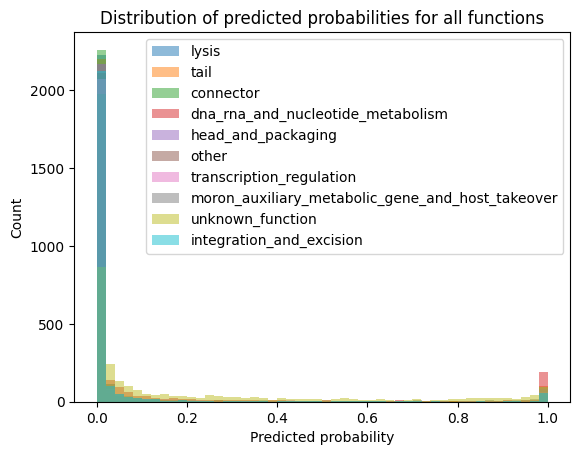

In [9]:
import matplotlib.pyplot as plt

for func in FUNCTION_NAMES:
    plt.hist(results_df[f"prob_{func}"], bins=50, alpha=0.5, label=func)
plt.legend()
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities for all functions")
plt.show()